In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prefix path
prefix = '/content/drive/MyDrive/데이터크리에이터캠프/CV/task1/jinwoo'

In [21]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [4]:
# tup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.11.219.34:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.11.219.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.219.34:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [5]:
# fashion dataset load
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [7]:
# make valid set
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, stratify=train_labels)

In [9]:
# dataset shape
train_images.shape, val_images.shape, test_images.shape

((45000, 28, 28), (15000, 28, 28), (10000, 28, 28))

In [10]:
# the number of classes
num_class = len(np.unique(test_labels))

In [11]:
# make one-hot label
train_labels = keras.utils.to_categorical(train_labels)
val_labels = keras.utils.to_categorical(val_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [12]:
# preprocess function
# normalize x
def preprocess(x, y):
  x = tf.cast(x, dtype=tf.float32)
  x = x/255.0
  x = tf.expand_dims(x, 3)
  return x, y

In [14]:
# make trainset
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(preprocess).shuffle(1000, seed=42)    # shuffle

val_dataset  = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.map(preprocess)

test_dataset  = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.map(preprocess)

In [15]:
with strategy.scope():
  # model
  model = keras.models.Sequential([
              keras.layers.Conv2D(8, 5, activation='relu', input_shape=(28, 28, 1)),
              keras.layers.MaxPool2D(pool_size=(3, 3)),
              keras.layers.Conv2D(16, 3, activation='relu'),
              keras.layers.MaxPool2D(pool_size=(2, 2)),
              keras.layers.Flatten(),
              keras.layers.Dense(20, activation='relu'),
              keras.layers.Dense(num_class, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics='accuracy'
  )

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2900      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

In [18]:
# callback method

# checkpoint path
ckpt_name = 'CNN_ckpt.hdf5'
checkpoint_dir_path = os.path.join(prefix, 'checkpoint')
checkpoint_path = os.path.join(prefix, 'checkpoint', ckpt_name)

# check checkpoint paht
# if not exist, make dir
if not(os.path.exists(checkpoint_dir_path)):
  os.mkdir(checkpoint_dir_path)

callbacks_list = [
    # save model weights, at every epoch
    tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        monitor='val_loss',
        mode='min',
        save_weights_only=True,
        save_best_only=True
    ),
    # EarlyStopping, if val_loss is not improved five times
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1, 
        patience=5
    )
]

In [19]:
hist = model.fit(train_dataset, validation_data=val_dataset, callbacks=callbacks_list, epochs=20)

Epoch 1/20
1407/1407 [==============================] - 27s 16ms/step - loss: 0.7325 - accuracy: 0.7356 - val_loss: 0.5269 - val_accuracy: 0.8075
Epoch 2/20
1407/1407 [==============================] - 19s 14ms/step - loss: 0.4708 - accuracy: 0.8312 - val_loss: 0.4639 - val_accuracy: 0.8352
Epoch 3/20
1407/1407 [==============================] - 19s 13ms/step - loss: 0.4186 - accuracy: 0.8502 - val_loss: 0.4226 - val_accuracy: 0.8520
Epoch 4/20
1407/1407 [==============================] - 19s 14ms/step - loss: 0.3885 - accuracy: 0.8609 - val_loss: 0.3914 - val_accuracy: 0.8601
Epoch 5/20
1407/1407 [==============================] - 19s 14ms/step - loss: 0.3656 - accuracy: 0.8676 - val_loss: 0.3798 - val_accuracy: 0.8639
Epoch 6/20
1407/1407 [==============================] - 20s 14ms/step - loss: 0.3485 - accuracy: 0.8752 - val_loss: 0.3637 - val_accuracy: 0.8713
Epoch 7/20
1407/1407 [==============================] - 19s 13ms/step - loss: 0.3376 - accuracy: 0.8778 - val_loss: 0.3497 -

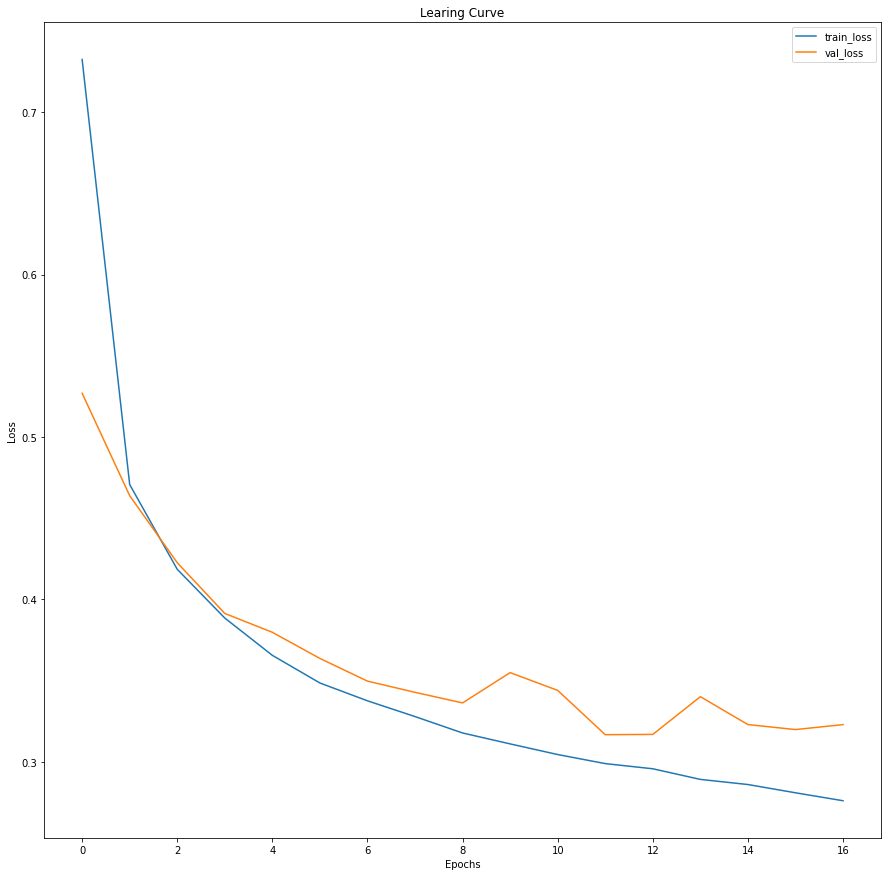

In [23]:
# learning curve
plt.figure(figsize=(15, 15))
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Learing Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [24]:
# load last ckpt weight
model.load_weights(checkpoint_path)

In [25]:
# evaluate test set
model.evaluate(test_dataset)

313/313 [==============================] - 6s 15ms/step - loss: 0.3368 - accuracy: 0.8808


[0.3368212878704071, 0.8807999491691589]